<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab  

  
*Authors:*
 - Joseph Nelson (DC)      
 - Boom Devahastin Na Ayudhya  (NYC)   
 - Bethany Poulin (Boston) 



---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as time series models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller  
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

data = pd.read_csv('./datasets/train.csv')
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.500,False
2010-02-12,1,1,46039.490,True
2010-02-19,1,1,41595.550,False
2010-02-26,1,1,19403.540,False
2010-03-05,1,1,21827.900,False


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3+ MB


In [3]:
data.index = pd.to_datetime(data.index)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3 MB


#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**

In [4]:
# Create mask for "Store 1" and apply to data.
mask = data['Store'] == 1
data = data[mask]

# Create dataframe called `Weekly_Sales`.
Weekly_Sales = pd.DataFrame(data['Weekly_Sales'].groupby(data.index).sum())

In [5]:
# Check to make sure we did this properly.
Weekly_Sales.head()

,Weekly_Sales
Date,
2010-02-05,1643690.900
2010-02-12,1641957.440
2010-02-19,1611968.170
2010-02-26,1409727.590
2010-03-05,1554806.680


#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

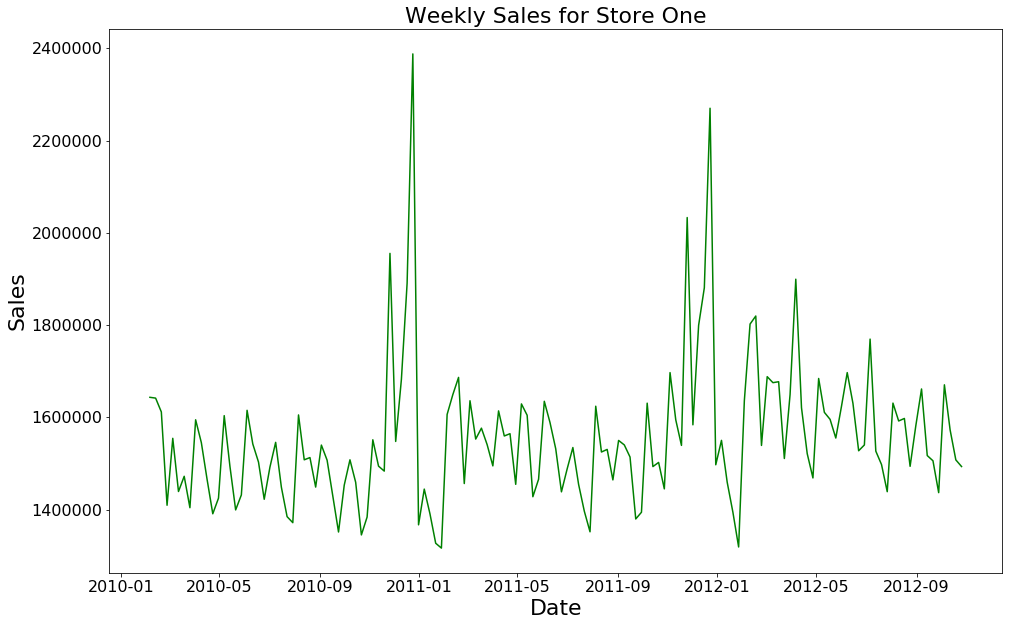

In [6]:
# Set figure size.
plt.figure(figsize=(16,10))

# Create line plot.
plt.plot(Weekly_Sales, c ='green')

# Set labels and title.
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Sales', fontsize=22)
plt.title('Weekly Sales for Store One', fontsize=22);

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

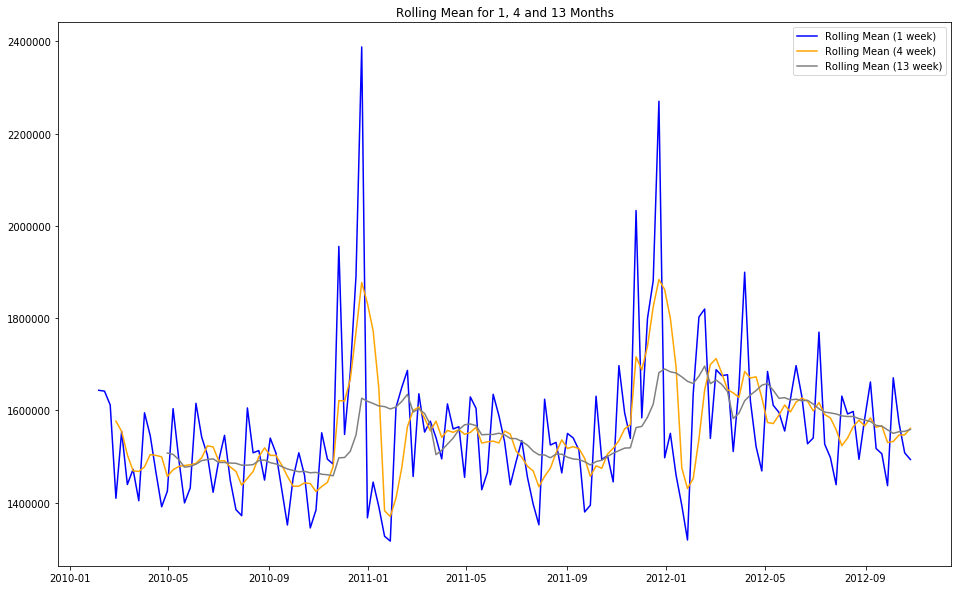

In [7]:
# Set a rolling mean with windows of 1, 4, and 13.
rolmean1  = Weekly_Sales.rolling(window = 1).mean()
rolmean4  = Weekly_Sales.rolling(window = 4).mean()
rolmean13 = Weekly_Sales.rolling(window = 13).mean()

# Plot
plt.figure(figsize=(16,10))
plt.plot(rolmean1, color='blue', label='Rolling Mean (1 week)')
plt.plot(rolmean4, color='orange', label='Rolling Mean (4 week)')
plt.plot(rolmean13, color='grey', label='Rolling Mean (13 week)')

plt.legend(loc='best')

plt.title('Rolling Mean for 1, 4 and 13 Months')
plt.show()

**2c. What can you say about trends in the data based on the rolling mean plot above?**

**Answer:** *(Answers may vary.)* 
- There are clearly spikes in the early year around January and February. This is most likely the result of huge increases for holiday spending in November and December.
- These spikes are followed, indicating a significant decrease in spending immediately following the holiday season. 
- We plot moving averages of 1, 4, and 13 weeks. 
    - 1 week is our default.
    - 4 weeks is approximately one month.
    - 13 weeks is approximately one season.

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

In [8]:
print(f'Autocorrelation between Weekly Sales and 1-lag Weekly_Sales: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=1),4)}')
print(f'Autocorrelation between Weekly Sales and 2-lag Weekly_Sales: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=2),4)}')
print(f'Autocorrelation between Weekly Sales and 52-lag Weekly_Sales: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=52),4)}')

Autocorrelation between Weekly Sales and 1-lag Weekly_Sales: 0.3022
Autocorrelation between Weekly Sales and 2-lag Weekly_Sales: 0.1274
Autocorrelation between Weekly Sales and 52-lag Weekly_Sales: 0.8954


**3b. What can you say about the series based on these autocorrelations?**

**Answer:** *(Answers may vary.)*
- The single week autocorrelation shows that there is a fair amount of influence on sales each week from the prior week.
- Looking at week two, it seems that the further away from the current week, we look back, the less influence that week's sales have on the current week's sales. It would be likely to consider that a lag of three would be even less correlated with the current week's sales.
- The 52-week lag of sales is strongly correlated with the current week's sales. This would suggest that there might be a seasonal influence working on sales separated by one year.

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

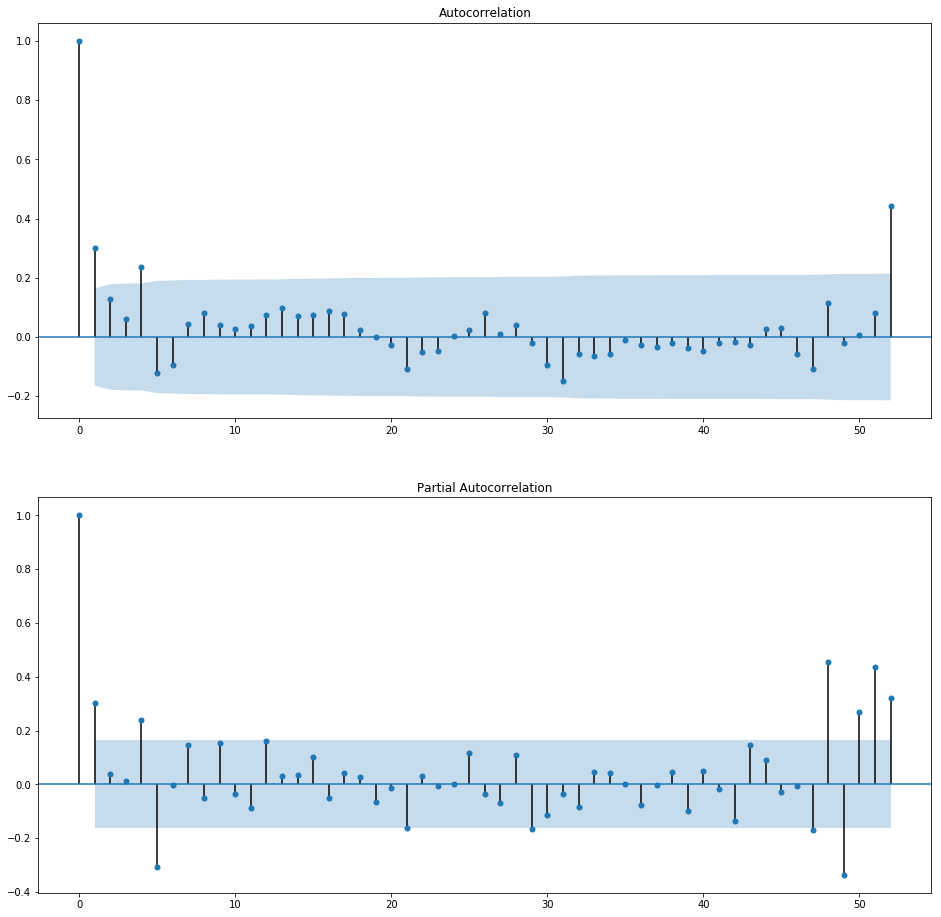

In [9]:
# 52-week  Autocorr and Partial Autocorr
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(211)
fig = plot_acf(Weekly_Sales, lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(Weekly_Sales, lags=52, ax=ax2);

# If you do not use plt.show() it will plot the same vizualization twice.
# This may be a bug you can fix and submit to contribute to open source!

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

**Answer:**

The filled blue space is representative of a 95% confidence interval. The points inside the blue space are likely to be noise, not any valuable correlation. Points outside the interval should be considered for further investigation.

The first point is meaningless: it represents the correlation between the `Weekly_Sales` and itself, so the correlation here should always be 1.

- At lag = 1, there is some relationship between the sales and prior day sales evidenced by both the ACF and PACF.
- At lag = 4, there seems to be a correlation in both the ACF and PACF, this might be due to a monthly sales promotion or some kind of monthly cycle in sales.
- At lag = 5 there is an interesting negative relationship which we cannot immediately infer about in the PACF (direct with no in-between relationships).
- At lag = 48, 50, 51, and 52 there is significant positive relationship in the PACF, possibly a correlation to monthly sales, within the seasonality of a year.
- At lag = 52, there is a clear correlation in both the ACF and PACF. This should give us a sense that there might be a seasonal component in the series.

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

**Answer:** *(Answers may vary.)* 

We recognize that there is some correlation at 1 week, at 4 or 5 weeks, and right around one year (48-52 weeks).
- This might help us determine our values of $p$ and $q$, as well as any seasonal component we might fit.

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data.

In [10]:
print(f'Number of observations: {len(Weekly_Sales)}')
print(f'Number of training observations: {round(len(Weekly_Sales) * 0.75)}')
print(f'Number of testing observations: {len(Weekly_Sales) - round(len(Weekly_Sales) * 0.75)}')

train = Weekly_Sales.iloc[:108,]

test = Weekly_Sales.iloc[108:,]

Number of observations: 143
Number of training observations: 107
Number of testing observations: 36


In [11]:
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train, c='blue')
    plt.plot(test, c='orange');

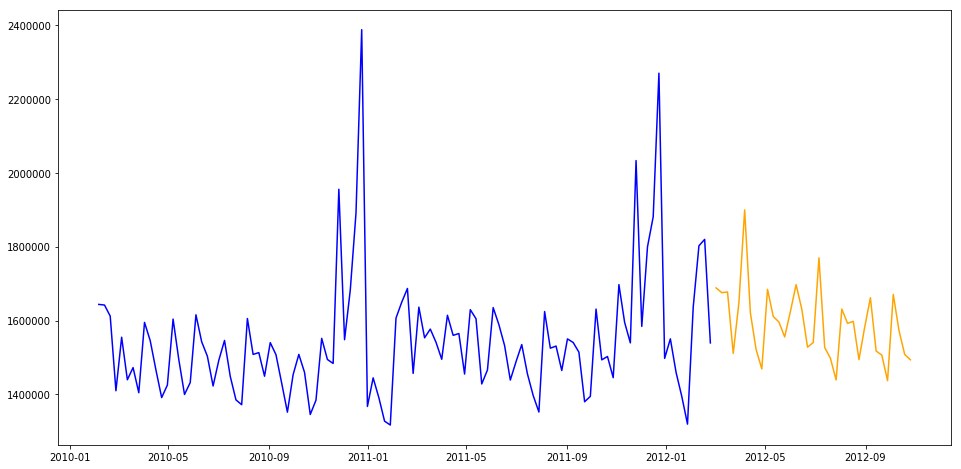

In [12]:
# This plot confirms that our function works properly.
# The gap between the train and test is to be expected
# because we aren't connecting the dots between our
# 107th and 108th observations.

train_test_plot(train, test)

#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. (*Note that this is the same thing as an ARIMA(1,0,0) model.*)

**6a. Instantiate and fit an `AR(1)` model.**

In [13]:
# Split training data into train values and dates.
train_values = train['Weekly_Sales'].values
train_dates = train.index

# Fit model on training data.
AR1 = AR(train_values, train_dates).fit()

# Split test data into values and dates.
test_values = test['Weekly_Sales'].values
test_dates  = test.index

# Create start and end dates for predictions
start = test.index[0]
end = test.index[-1]

# Generate predictions on starting and ending dates.
AR1_pred = AR1.predict(start = start,
                       end = end)

In [14]:
# Put predictions into a dataframe with a date range.
date_list =  pd.date_range(start, periods=35, freq ='W')
preds = pd.DataFrame(AR1_pred, index=date_list, columns = ['Weekly Sales'])

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [15]:
# Calculate MSE.
error = mean_squared_error(test_values, preds)
print(f'MSE: {round(error, 2)}')

MSE: 9834237361.27


**6c. How effective do you think this `AR(1)` model is?**

In [16]:
# Look at min and max sales, as well as how our MSE compares to them.
print(f'Minimum Sales: {round(Weekly_Sales["Weekly_Sales"].min(),2)}')
print(f'Maximum Sales: {round(Weekly_Sales["Weekly_Sales"].max(),2)}')
print(f'MSE relative to minimum values in series: {round(error / Weekly_Sales["Weekly_Sales"].min(),2)}.')
print(f'MSE relative to maximum values in series: {round(error / Weekly_Sales["Weekly_Sales"].max(),2)}.')

Minimum Sales: 1316899.31
Maximum Sales: 2387950.2
MSE relative to minimum values in series: 7467.72.
MSE relative to maximum values in series: 4118.28.


**Answer:** Looking at the ratio of the *mean* error to the minimum and maximum values in the series, it does not seem terrible. However (as we'll see shortly), when you look at the decay in the predictions based on the graph, it is clear that earlier predictions have less erroneous than later predictions, so improvement is probably necessary to use this model as is.

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

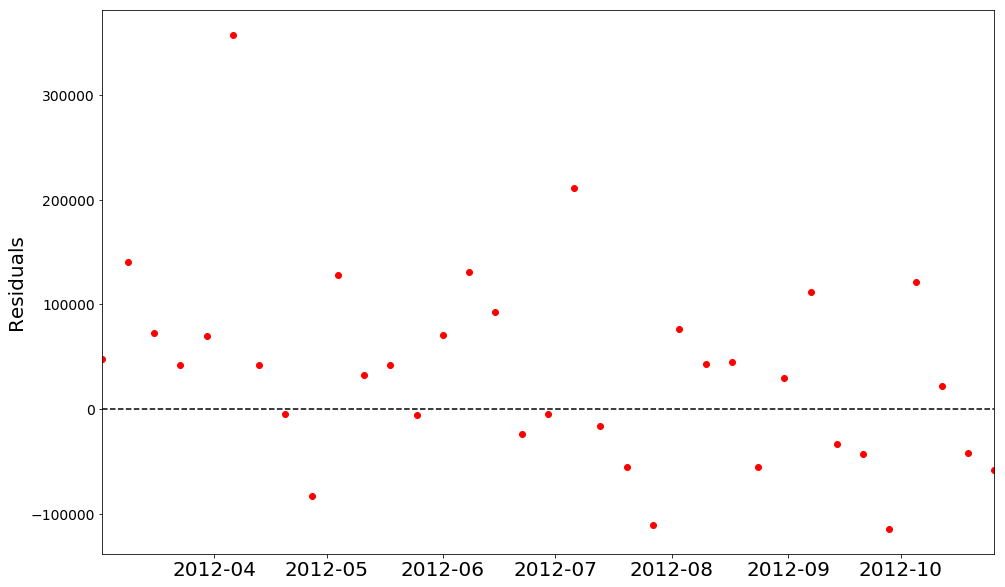

In [17]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['Weekly_Sales'].values - preds['Weekly Sales'].values

# Generate scatterplot of residuals.
plt.scatter(test['Weekly_Sales'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

**7b. What do the residual plots reveal about our model?**

**Answer:** There are some days where the prediction is off more than others. This could be specific to those days, or it could be a limit of the model. It looks like early time periods are predicting too low (residuals = true - predicted values are high) and later time periods are predicting closer to accurate (residuals centered around 0).

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

Training MSE: 25669024742.816803
Testing MSE: 11333862408.15982


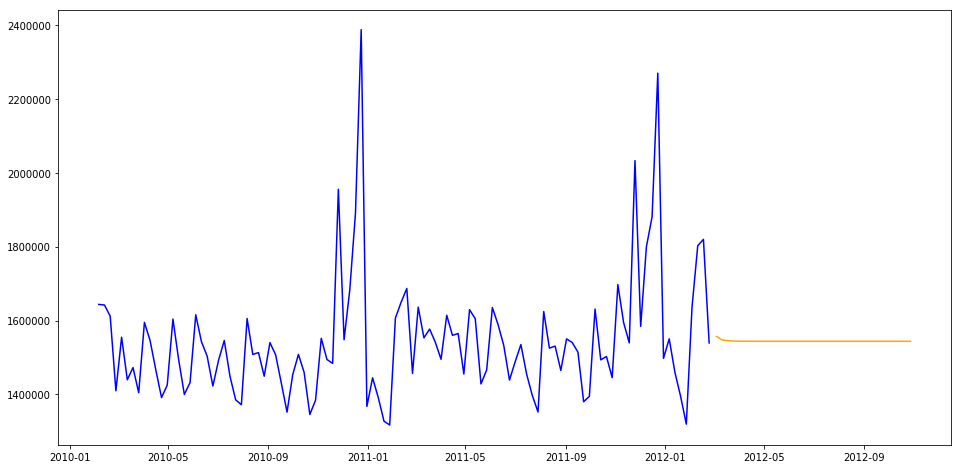

In [18]:
# Fit an AR(2) model.
AR2 = ARIMA(endog = train_values,
            dates = train_dates,
            order = (2,0,0)).fit()

# Generate predictions.
AR2_pred = AR2.predict(start = start,
                       end = end)

# Evaluate our model on the trainign and testing sets.
print(f'Training MSE: {mean_squared_error(train_values, AR2.predict())}')
print(f'Testing MSE: {mean_squared_error(test_values, AR2_pred)}')

preds = pd.DataFrame(AR2_pred, index=date_list, columns = ['Weekly Sales'])

train_test_plot(train, preds)

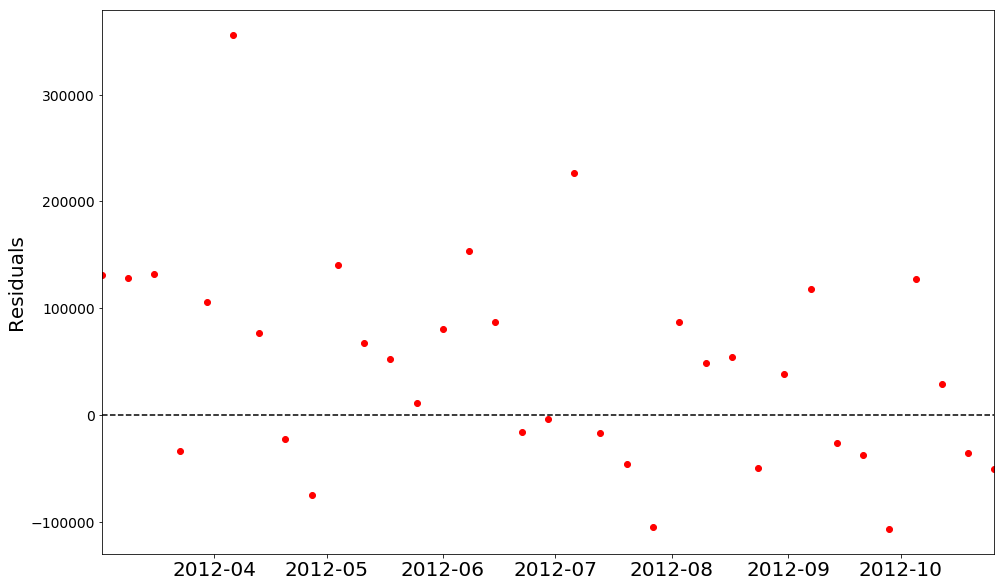

In [19]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['Weekly_Sales'].values - preds['Weekly Sales'].values

# Generate scatterplot of residuals.
plt.scatter(test['Weekly_Sales'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

**8b. How did your results change?**

**Answer:** The results got worse. Looking at the line plot, it seems as though the model removed all variation in the sales, creating a set of flat predictions.

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

Training MSE: 21365569166.6247
Testing MSE: 11347833863.230904


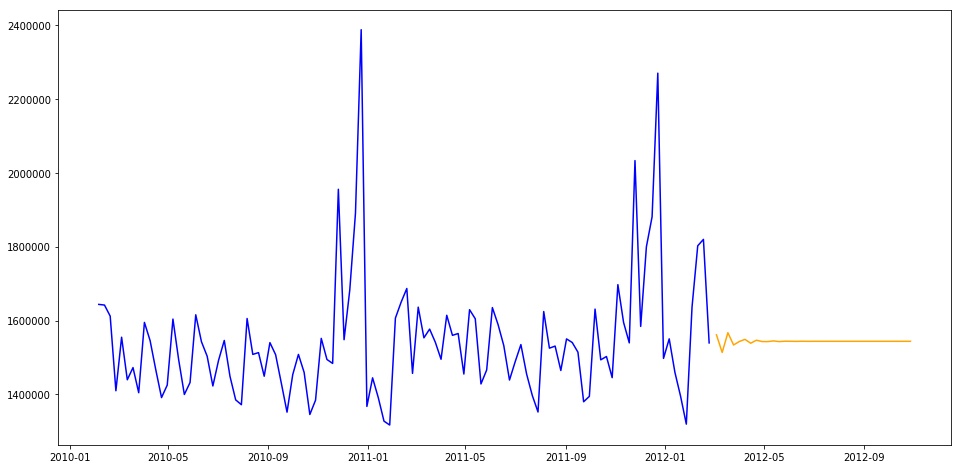

In [20]:
# Fit an AR(2,2) model.
AR2_2 = ARIMA(endog = train_values,
              dates = train_dates,
              order = (2,0,2)).fit()

# Generate predictions.
AR2_2_pred = AR2_2.predict(start = start,
                           end = end)

# Evaluate our model on the trainign and testing sets.
print(f'Training MSE: {mean_squared_error(train_values, AR2_2.predict())}')
print(f'Testing MSE: {mean_squared_error(test_values, AR2_2_pred)}')

preds = pd.DataFrame(AR2_2_pred, index=date_list, columns = ['Weekly Sales'])

train_test_plot(train, preds)

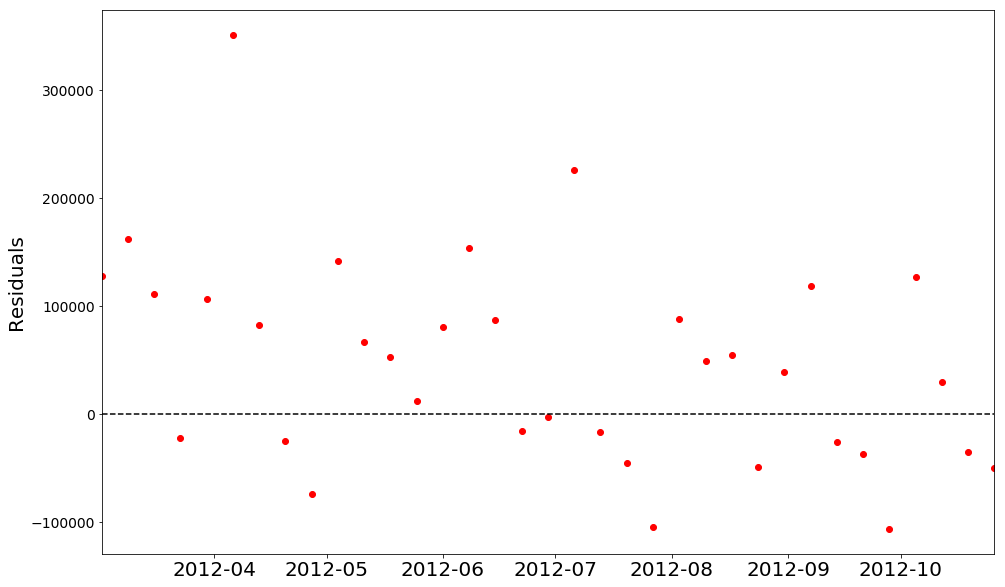

In [21]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['Weekly_Sales'].values - preds['Weekly Sales'].values

# Generate scatterplot of residuals.
plt.scatter(test['Weekly_Sales'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

**8d. How do the errors change from `AR(2)` to `ARMA(2,2)`?**



**Answer**: Both the MSE and graphs are considerably worse in the `AR(2)` and `ARMA(2,2)` models than when we fit an `AR(1)` model. As you might expect, the residuals are also worse in both `AR(2)` and `ARMA(2,2)` models.

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [22]:
def my_dickey_fuller(data):
    data = data.dropna()
    print('\t\t\033[1mResults of Dickey-Fuller Test\033[0m\n\n')
    df_test = adfuller(data, maxlag=0, autolag=None)
    
    print(f'Test Statistic \t\t\t\t {round(df_test[0],2)}')
    print(f'p-value \t\t\t\t {df_test[1]}')
    print(f'Lags Used \t\t\t\t {round(df_test[2],2)}')
    print(f'Number of Observations \t\t\t {round(df_test[3],2)}')
    
    for key, value in df_test[4].items():
        print(f'Critical Value {key} \t\t\t {round(value, 2)}')

In [23]:
my_dickey_fuller(train['Weekly_Sales'])

		Results of Dickey-Fuller Test


Test Statistic 				 -7.46
p-value 				 5.277167250610254e-11
Lags Used 				 0
Number of Observations 			 107
Critical Value 1% 			 -3.49
Critical Value 5% 			 -2.89
Critical Value 10% 			 -2.58


**9b. Interpret the results of the Augmented Dickey-Fuller test.**

**Answer**: Because $p \approx 5.27\times 10^{-11} < 0.05 = \alpha$, we reject $H_0$ that our data are not stationary and accept $H_A$ that our data are stationary. This means we can fit an ARIMA model to this data without differencing.

#### 10. Differenced Data

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [24]:
Weekly_Sales['diff_1'] = Weekly_Sales['Weekly_Sales'].diff()
Weekly_Sales['diff_2'] = Weekly_Sales['Weekly_Sales'].diff(2)
Weekly_Sales['diff_3'] = Weekly_Sales['Weekly_Sales'].diff(3)
Weekly_Sales.head()

,Weekly_Sales,diff_1,diff_2,diff_3
Date,,,,
2010-02-05,1643690.900,nan,nan,nan
2010-02-12,1641957.440,-1733.460,nan,nan
2010-02-19,1611968.170,-29989.270,-31722.730,nan
2010-02-26,1409727.590,-202240.580,-232229.850,-233963.310
2010-03-05,1554806.680,145079.090,-57161.490,-87150.760


**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [25]:
print('Original Data')
print('')
my_dickey_fuller(Weekly_Sales['Weekly_Sales'])
print('')
for diff in range(1,4):
    print(f'Data Differenced by d = {diff}')
    print('')
    my_dickey_fuller(Weekly_Sales[f'diff_{diff}'])
    print('')

Original Data

		Results of Dickey-Fuller Test


Test Statistic 				 -8.67
p-value 				 4.596827441076283e-14
Lags Used 				 0
Number of Observations 			 142
Critical Value 1% 			 -3.48
Critical Value 5% 			 -2.88
Critical Value 10% 			 -2.58

Data Differenced by d = 1

		Results of Dickey-Fuller Test


Test Statistic 				 -17.5
p-value 				 4.3860500615947114e-30
Lags Used 				 0
Number of Observations 			 141
Critical Value 1% 			 -3.48
Critical Value 5% 			 -2.88
Critical Value 10% 			 -2.58

Data Differenced by d = 2

		Results of Dickey-Fuller Test


Test Statistic 				 -10.21
p-value 				 5.551624171727023e-18
Lags Used 				 0
Number of Observations 			 140
Critical Value 1% 			 -3.48
Critical Value 5% 			 -2.88
Critical Value 10% 			 -2.58

Data Differenced by d = 3

		Results of Dickey-Fuller Test


Test Statistic 				 -10.31
p-value 				 3.2166647330955138e-18
Lags Used 				 0
Number of Observations 			 139
Critical Value 1% 			 -3.48
Critical Value 5% 			 -2.88
Critical Value

**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

**Answer**: The data appear to be stationary in all cases. Since the smallest differencing needed is $d = 0$, I recommend not differencing.
- Note that our answer for $d = 0$ is slightly different than in the last problem because we are executing the Augmented Dickey-Fuller test on just our training data in the last problem and on all data (train and test) in this problem.

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

**Answer:** Given that the data seems more stationary, it might make sense to try an ARIMA with a differenced value. It may or may not improve the model, but let's try it!

#### 11.  ARIMA Model

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Evaluate your model on the training and testing sets and generate a residual plot.**

In [26]:
# I know fitting d = 0 seems to be best. I'll try fitting a 
# model with d = 1 to see if this improves anything.

ARIMA_2_1_2 = ARIMA(endog = train_values, dates = train_dates, order = (2,1,2)).fit()

ARIMA_2_1_2_pred = ARIMA_2_1_2.predict(start=start, end = end)

mean_squared_error(test_values, ARIMA_2_1_2_pred)

LinAlgError: SVD did not converge

**11b. Interpret the results from the last answer.**

**Answer**: 

This error (**LinAlgError: SVD did not converge**) occurs when there is an underlying problem in the order of the ARIMA. Having `d=1` breaks our model. In short, it has to do with the matrix operations underlying the actual fitting of the model.

#### 12. BONUS: SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

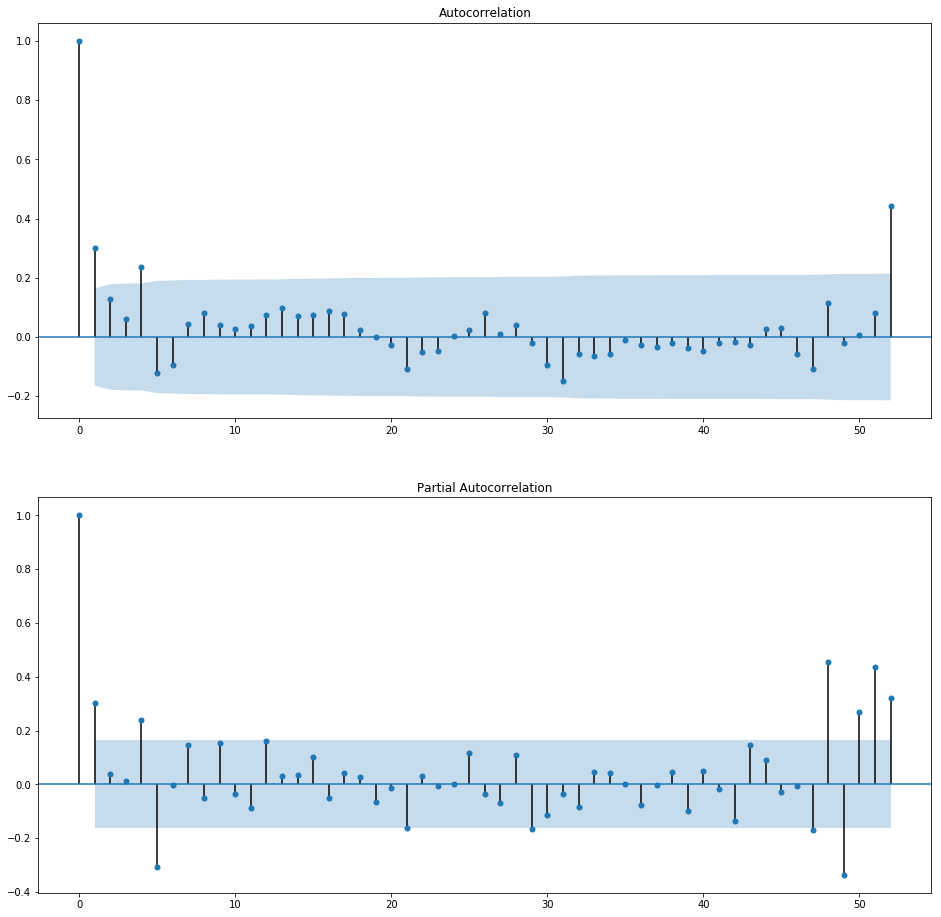

In [27]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(211)
fig = plot_acf(Weekly_Sales.Weekly_Sales, lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(Weekly_Sales.Weekly_Sales, lags=52, ax=ax2)
plt.show();

In [28]:
import time
t0 = time.time()
final_mse = 10000000000000
final_S = 0
final_D = 0
final_P = 0
final_Q = 0

for S in range(48,56):
    for D in range(4):
        for P in range(4):
            for Q in range(4):
                print(f'Checking ({P}, {D}, {Q}, {S}) at {round(time.time() - t0)} seconds.')
                try:
                    sarima = SARIMAX(endog = train['Weekly_Sales'].dropna(),
                                     order = (2, 0, 2),
                                     seasonal_order = (P, D, Q, S)).fit()

                    sarima_pred = sarima.predict(start=start, end = end)

                    if mean_squared_error(test_values, sarima_pred) < final_mse:
                        final_mse = mean_squared_error(test_values, sarima_pred)
                        final_S = S
                        final_D = D
                        final_P = P
                        final_Q = Q

                    print(f'We just fit a SARIMAX(2, 0, 2)x({P}, {D}, {Q}, {S}) model with {mean_squared_error(test_values, sarima_pred)} MSE.')

                except:
                    pass

print(f'The final model is SARIMAX(2, 0, 2)x({final_P}, {final_D}, {final_Q}, {final_S}).')

Checking (0, 0, 0, 48) at 0 seconds.
Checking (0, 0, 1, 48) at 0 seconds.
Checking (0, 0, 2, 48) at 0 seconds.
Checking (0, 0, 3, 48) at 0 seconds.
Checking (1, 0, 0, 48) at 0 seconds.
Checking (1, 0, 1, 48) at 0 seconds.
Checking (1, 0, 2, 48) at 0 seconds.
Checking (1, 0, 3, 48) at 0 seconds.
Checking (2, 0, 0, 48) at 0 seconds.
Checking (2, 0, 1, 48) at 0 seconds.
Checking (2, 0, 2, 48) at 0 seconds.
Checking (2, 0, 3, 48) at 0 seconds.
Checking (3, 0, 0, 48) at 0 seconds.
Checking (3, 0, 1, 48) at 0 seconds.
Checking (3, 0, 2, 48) at 0 seconds.
Checking (3, 0, 3, 48) at 0 seconds.
Checking (0, 1, 0, 48) at 0 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 1, 0, 48) model with 20899310590.241 MSE.
Checking (0, 1, 1, 48) at 1 seconds.
Checking (0, 1, 2, 48) at 1 seconds.
Checking (0, 1, 3, 48) at 1 seconds.
Checking (1, 1, 0, 48) at 1 seconds.
Checking (1, 1, 1, 48) at 1 seconds.
Checking (1, 1, 2, 48) at 1 seconds.
Checking (1, 1, 3, 48) at 1 seconds.
Checking (2, 1, 0, 48) at 1 seconds

We just fit a SARIMAX(2, 0, 2)x(1, 1, 0, 51) model with 24613790978.643497 MSE.
Checking (1, 1, 1, 51) at 41 seconds.
Checking (1, 1, 2, 51) at 41 seconds.
Checking (1, 1, 3, 51) at 41 seconds.
Checking (2, 1, 0, 51) at 41 seconds.
Checking (2, 1, 1, 51) at 41 seconds.
Checking (2, 1, 2, 51) at 41 seconds.
Checking (2, 1, 3, 51) at 41 seconds.
Checking (3, 1, 0, 51) at 41 seconds.
Checking (3, 1, 1, 51) at 41 seconds.
Checking (3, 1, 2, 51) at 41 seconds.
Checking (3, 1, 3, 51) at 41 seconds.
Checking (0, 2, 0, 51) at 41 seconds.
Checking (0, 2, 1, 51) at 41 seconds.
Checking (0, 2, 2, 51) at 41 seconds.
Checking (0, 2, 3, 51) at 41 seconds.
Checking (1, 2, 0, 51) at 41 seconds.
Checking (1, 2, 1, 51) at 41 seconds.
Checking (1, 2, 2, 51) at 41 seconds.
Checking (1, 2, 3, 51) at 41 seconds.
Checking (2, 2, 0, 51) at 41 seconds.
Checking (2, 2, 1, 51) at 41 seconds.
Checking (2, 2, 2, 51) at 41 seconds.
Checking (2, 2, 3, 51) at 41 seconds.
Checking (3, 2, 0, 51) at 41 seconds.
Checking

Checking (0, 3, 2, 54) at 50 seconds.
Checking (0, 3, 3, 54) at 50 seconds.
Checking (1, 3, 0, 54) at 50 seconds.
Checking (1, 3, 1, 54) at 50 seconds.
Checking (1, 3, 2, 54) at 50 seconds.
Checking (1, 3, 3, 54) at 50 seconds.
Checking (2, 3, 0, 54) at 50 seconds.
Checking (2, 3, 1, 54) at 50 seconds.
Checking (2, 3, 2, 54) at 50 seconds.
Checking (2, 3, 3, 54) at 50 seconds.
Checking (3, 3, 0, 54) at 50 seconds.
Checking (3, 3, 1, 54) at 50 seconds.
Checking (3, 3, 2, 54) at 50 seconds.
Checking (3, 3, 3, 54) at 50 seconds.
Checking (0, 0, 0, 55) at 50 seconds.
Checking (0, 0, 1, 55) at 50 seconds.
Checking (0, 0, 2, 55) at 50 seconds.
Checking (0, 0, 3, 55) at 50 seconds.
Checking (1, 0, 0, 55) at 50 seconds.
Checking (1, 0, 1, 55) at 50 seconds.
Checking (1, 0, 2, 55) at 50 seconds.
Checking (1, 0, 3, 55) at 50 seconds.
Checking (2, 0, 0, 55) at 50 seconds.
Checking (2, 0, 1, 55) at 50 seconds.
Checking (2, 0, 2, 55) at 50 seconds.
Checking (2, 0, 3, 55) at 50 seconds.
Checking (3,

In [29]:
sarima = SARIMAX(endog = train['Weekly_Sales'].dropna(),
                 order = (2, 0, 2),
                 seasonal_order = (0, 1, 0, 53)).fit()

sarima_pred = sarima.predict(start=start, end = end)

In [30]:
mean_squared_error(test_values, sarima_pred)

14145872389.386002

**12b. How did your best SARIMAX model perform?**

Answer: Our model visually looks like it performs well. It also has an MSE of
14145872389.386002, which means that our predictions are on average about 120,000 off from correct. We would like this to be better, but since we're looking at between 1.5 and 2 million units for each value, this is much better than it could be!

### 13. Your Best Model

**13a. In the cells below, bring together your best model, including:**
- any summaries, 
- graphs of the data and residuals, 
- the predictions,
- and how you decided this was your best model.

In [31]:
sarima = SARIMAX(endog = train['Weekly_Sales'].dropna(),
                 order = (2, 0, 2),
                 seasonal_order = (0, 1, 0, 53)).fit()

sarima_pred = sarima.predict(start=start, end = end)

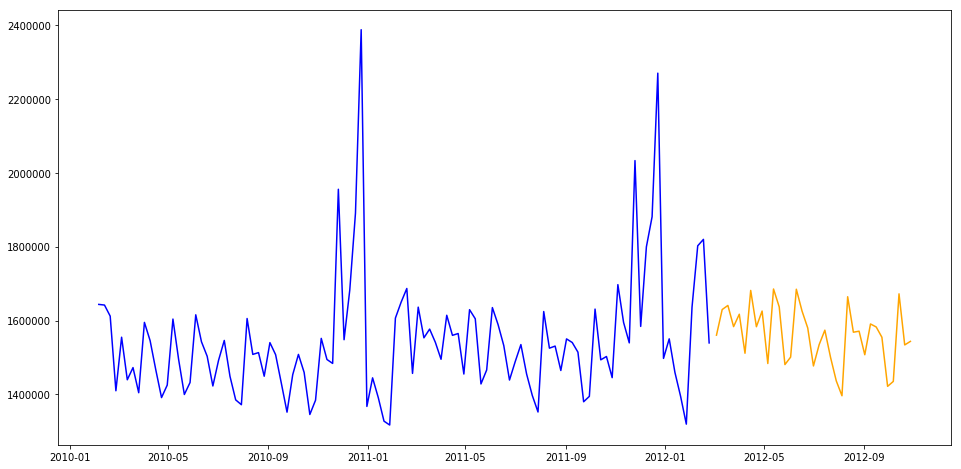

In [32]:
preds = pd.DataFrame(sarima_pred.values, index=date_list, columns = ['Weekly Sales'])
train_test_plot(train, preds)

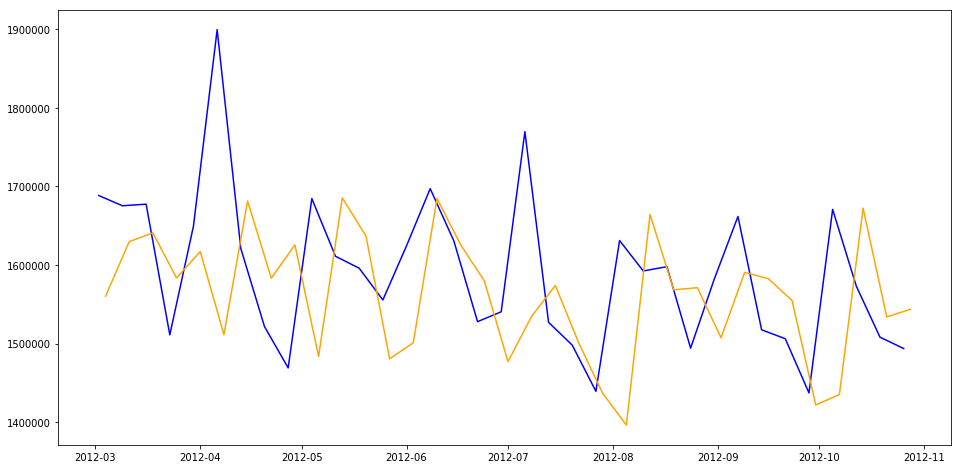

In [33]:
plt.figure(figsize=(16, 8))
plt.plot(test, c='blue')
plt.plot(preds, c='orange');

**13b. How does our model perform at predicting weekly sales moving forward?** 

**Answer:**

Our model has an MSE of 14145872389.386002, which means that our predictions are on average about 120,000 off from correct. It mirrors the cyclical nature of our predictions better than our older models.

**13c. How might you improve it?**

**Answer:**
- We could use more years of data, if available.
- We can bring in relevant exogenous data to help account for variations. 
- It might be a good place to look at the residual errors in places where they were extreme to investigate why our predictions were off. (For example, shorter or longer hours, the release of a hotly anticipated item, were there spikes due to anticipated storms, etc.)

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations**.

In [34]:
# Helper function to get first week of month in given date list
def get_first_weeks(date_list):
    firstweeks = []
    for position, date in enumerate(date_list):
        if position > 0:
            if str(date)[5:7] != str(date_list[position-1])[5:7]: firstweeks.append(date)
    return(firstweeks)

The Mean Squared Error is: 10528132920.32591


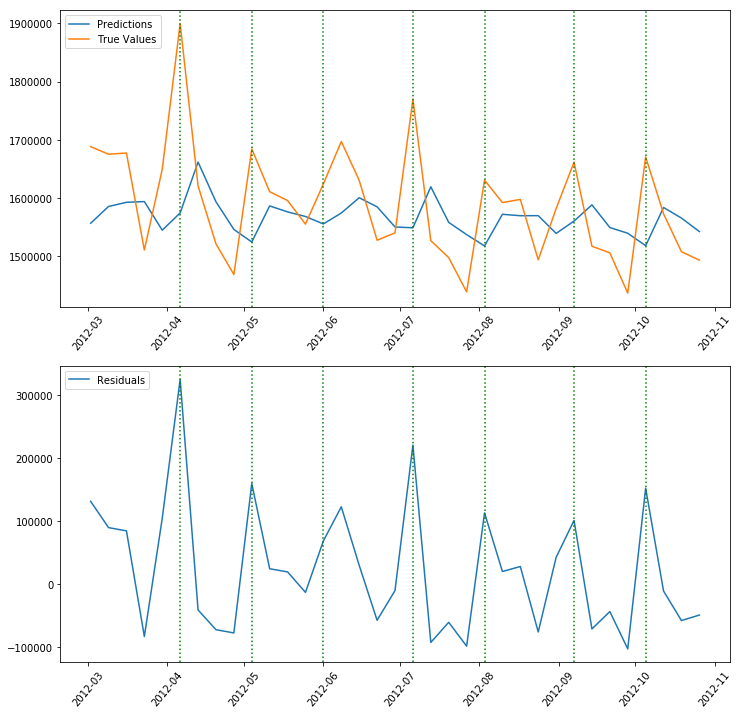

In [35]:
## rolling predictions for AR(2) model 

predictions_rolling = []
training_observations = list(train['Weekly_Sales'].values)
testing_observations = test['Weekly_Sales'].values

for obs in testing_observations:
    model_roll = ARMA(training_observations, (2,0)).fit(disp=0)
    predictions_rolling.append(model_roll.forecast()[0][0])
    training_observations.append(obs)
    
MSE = mean_squared_error(test['Weekly_Sales'], predictions_rolling)
print("The Mean Squared Error is:", MSE)

residuals = test['Weekly_Sales'] - predictions_rolling


fig , (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,12))

ax1.tick_params('x', rotation=50)
ax1.plot(test.index, predictions_rolling, label='Predictions')
ax1.plot(test.index, testing_observations, label='True Values')
for xc in get_first_weeks(list(test.index)):
    ax1.axvline(x=xc, color='g', linestyle=':')
ax1.legend()

ax2.tick_params('x', rotation=50)
ax2.plot(test.index, residuals, label= "Residuals")
for xc in get_first_weeks(list(test.index)):
    ax2.axvline(x=xc, color='g', linestyle=':')
ax2.legend();